In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
import re
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import TensorFlow
import tensorflow as tf

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


def get_synonym(word):
    synonyms = nltk.corpus.wordnet.synsets(word)
    if synonyms:
        return random.choice(synonyms[0].lemma_names())
    else:
        return word

def augment_text(text, n=1):
    augmented_texts = []
    words = nltk.word_tokenize(text)

    for _ in range(n):
        augmented_text = words.copy()

        # Random Deletion
        augmented_text = [word for word in augmented_text if random.uniform(0, 1) > 0.2]

        # Random Swap
        for _ in range(2):
            if len(augmented_text) >= 2:
                idx1, idx2 = random.sample(range(len(augmented_text)), 2)
                augmented_text[idx1], augmented_text[idx2] = augmented_text[idx2], augmented_text[idx1]

        # Random Insertion
        for _ in range(2):
            if augmented_text:
                idx = random.randint(0, len(augmented_text) - 1)
                word = get_synonym(augmented_text[idx])
                augmented_text.insert(idx, word)

        augmented_texts.append(' '.join(augmented_text))

    return augmented_texts

# Load the dataset
dataset_path = r'All questions answers of Stack Exchange.csv'
df = pd.read_csv(dataset_path, encoding='latin1')

# Select relevant columns for classification
selected_columns = ['QuestionTitle', 'QuestionBody',  'Negotiation']
df = df[selected_columns]

# Clean and preprocess text data
df['text'] = df['QuestionTitle'] + ' ' + df['QuestionBody'] 

# Convert to lowercase
df['text'] = df['text'].str.lower()

# Remove punctuation
df['text'] = df['text'].astype(str).apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Remove stopwords
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Data augmentation using the augment_text function
augmented_texts = []
for text in df['text']:
    augmented_texts.extend(augment_text(text, n=1))  # Augment each text 1 time

# Combine original and augmented texts
df_augmented = pd.DataFrame({'text': df['text'].tolist() + augmented_texts, 'Negotiation': df['Negotiation'].tolist() + [neg for neg in df['Negotiation'].tolist() for _ in range(1)]})

# Preprocess the augmented data
df_augmented.dropna(inplace=True)  # Drop rows with missing values

# Get unique classes and clean negotiation names
df_augmented['Negotiation'] = df_augmented['Negotiation'].str.strip().str.lower()  # Remove extra spaces and convert to lowercase
unique_negotiations_augmented = df_augmented['Negotiation'].unique()  # Directly get unique classes

# Split the augmented data into training and testing sets
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(df_augmented['text'], df_augmented['Negotiation'], test_size=0.2, random_state=42)

# Define maximum number of words to consider as features
max_features = 5000

# Define maximum length of a sequence
max_sequence_length = 200

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_augmented['text'])

X_train_augmented = tokenizer.texts_to_sequences(X_train_augmented)
X_test_augmented = tokenizer.texts_to_sequences(X_test_augmented)

# Pad sequences with zeros to make all sequences of the same length
X_train_augmented = pad_sequences(X_train_augmented, maxlen=max_sequence_length)
X_test_augmented = pad_sequences(X_test_augmented, maxlen=max_sequence_length)

# Convert categorical labels to numerical
encoder_augmented = LabelEncoder()
y_train_encoded_augmented = encoder_augmented.fit_transform(y_train_augmented)
y_test_encoded_augmented = encoder_augmented.transform(y_test_augmented)

# Define oversampling strategy for augmented data
oversample_augmented = RandomOverSampler(sampling_strategy='minority')

# Fit and apply the transform for augmented data
X_over_augmented, y_over_augmented = oversample_augmented.fit_resample(X_train_augmented, y_train_encoded_augmented)

# Convert numerical labels to one-hot vectors for augmented data
y_train_one_hot_augmented = to_categorical(y_over_augmented)
y_test_one_hot_augmented = to_categorical(y_test_encoded_augmented)

# Define the Bidirectional RNN model for augmented data
model_augmented = Sequential()

# Embedding layer with dimension size 512 (found from grid search)
model_augmented.add(Embedding(input_dim=max_features, output_dim=512, input_length=max_sequence_length))  # Best 'embedding_dim' from grid search

# Bidirectional RNN Layer
model_augmented.add(Bidirectional(LSTM(64, return_sequences=True)))

# Pooling Layer
model_augmented.add(GlobalMaxPooling1D())

# Fully Connected Layer
model_augmented.add(Dense(64, activation='relu'))

# Output Layer
model_augmented.add(Dense(len(unique_negotiations_augmented), activation='softmax'))

# Compile the model with a learning rate of 0.01 (found from grid search)
model_augmented.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])  # Best 'learning_rate' from grid search

# Train the model with oversampled augmented data for 50 epochs with batch size 64 (found from grid search)
model_augmented.fit(X_over_augmented, y_train_one_hot_augmented, epochs=50, batch_size=64, verbose=0)  # Best 'epochs' and 'batch_size' from grid search

# Make predictions on the augmented test set
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    predictions_augmented = model_augmented.predict(X_test_augmented)

# Convert predictions from one-hot vectors to labels for augmented data
predictions_augmented = encoder_augmented.inverse_transform(predictions_augmented.argmax(axis=1))

# Print Grid Search Parameters used in the RNN Bidirectional LSTM model 
print("\n Parameters used in the RNN Bidirectional LSTM model:")
print(f"- Embedding Dimension: 512")
print(f"- Learning Rate: 0.01")
print(f"- Batch Size: 64")
print(f"- Number of Epochs: 50")
print()

# Evaluate the performance of the classifier with augmented data
accuracy_augmented = accuracy_score(y_test_augmented, predictions_augmented)
print(f'Deep Learning Model Accuracy with Augmented Data RNN Bidirectional LSTM model: {accuracy_augmented:.2f}')

# Display classification report for augmented data
print('\nClassification Report for Deep Learning Model with Augmented Data:\n', classification_report(y_test_augmented, predictions_augmented, labels=unique_negotiations_augmented, zero_division=1))


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step

 Parameters used in the RNN Bidirectional LSTM model:
- Embedding Dimension: 512
- Learning Rate: 0.01
- Batch Size: 64
- Number of Epochs: 50

Deep Learning Model Accuracy with Augmented Data RNN Bidirectional LSTM model: 0.78

Classification Report for Deep Learning Model with Augmented Data:
               precision    recall  f1-score   support

  conceptual       0.67      0.68      0.68       260
 theoretical       0.58      0.52      0.55       161
    learning       0.86      0.84      0.85        61
     tooling       0.82      0.88      0.85       233
      errors       0.91      0.93      0.92       336
   api usage       0.77      0.67      0.72        81

    accuracy                           0.78      1132
   macro avg       0.77      0.75      0.76      1132
weighted avg       0.78      0.78      0.78      1132



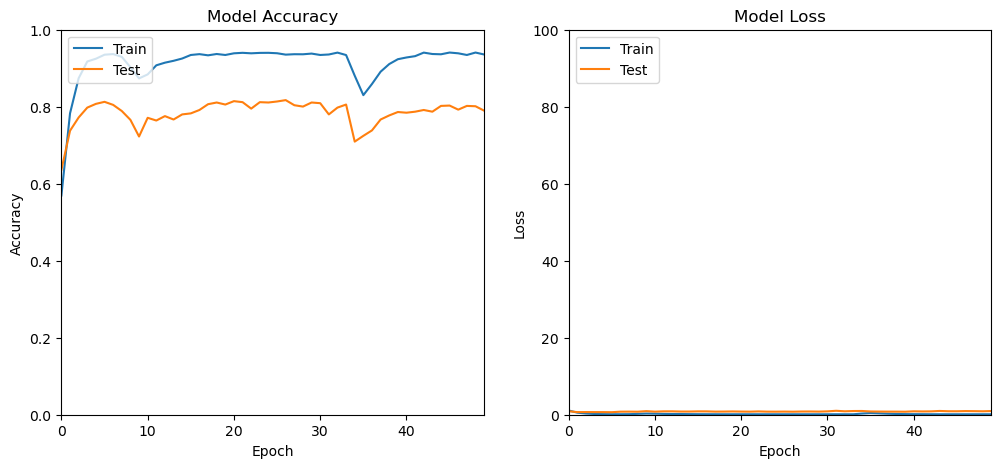

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step


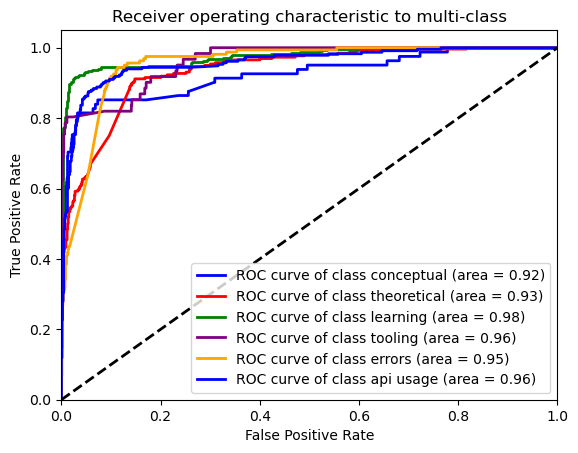

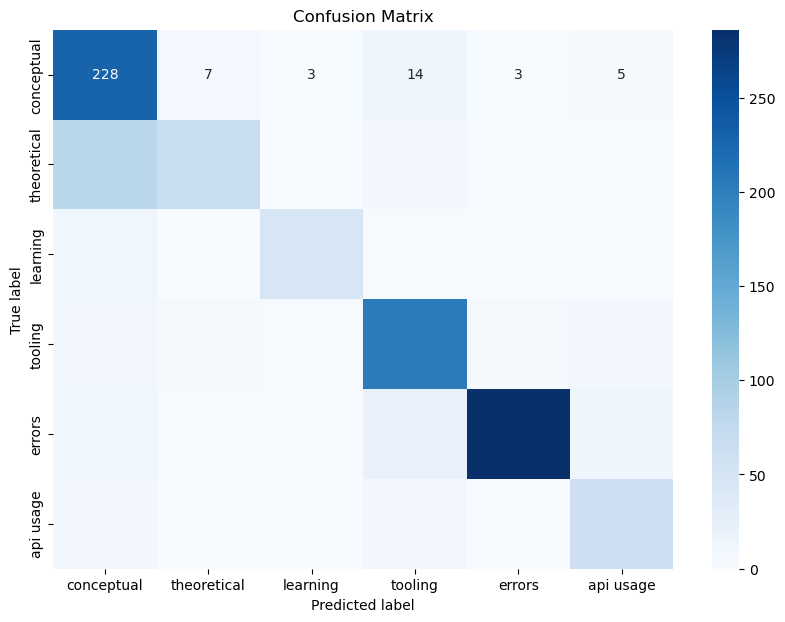

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
import re
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# Function to get a synonym
def get_synonym(word):
    synonyms = nltk.corpus.wordnet.synsets(word)
    if synonyms:
        return random.choice(synonyms[0].lemma_names())
    else:
        return word

def augment_text(text, n=1):
    augmented_texts = []
    words = nltk.word_tokenize(text)
    for _ in range(n):
        augmented_text = words.copy()
        augmented_text = [word for word in augmented_text if random.uniform(0, 1) > 0.2]
        for _ in range(2):
            if len(augmented_text) >= 2:
                idx1, idx2 = random.sample(range(len(augmented_text)), 2)
                augmented_text[idx1], augmented_text[idx2] = augmented_text[idx2], augmented_text[idx1]
        for _ in range(2):
            if augmented_text:
                idx = random.randint(0, len(augmented_text) - 1)
                word = get_synonym(augmented_text[idx])
                augmented_text.insert(idx, word)
        augmented_texts.append(' '.join(augmented_text))
    return augmented_texts

# Load and preprocess dataset
dataset_path = r'All questions answers of Stack Exchange.csv'
df = pd.read_csv(dataset_path, encoding='latin1')
selected_columns = ['QuestionTitle', 'QuestionBody',  'Negotiation']
df = df[selected_columns]
df['text'] = df['QuestionTitle'] + ' ' + df['QuestionBody']
df['text'] = df['text'].str.lower()
df['text'] = df['text'].astype(str).apply(lambda x: re.sub(r'[^\w\s]', '', x))
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
augmented_texts = []
for text in df['text']:
    augmented_texts.extend(augment_text(text, n=1))
df_augmented = pd.DataFrame({'text': df['text'].tolist() + augmented_texts, 'Negotiation': df['Negotiation'].tolist() + [neg for neg in df['Negotiation'].tolist() for _ in range(1)]})
df_augmented.dropna(inplace=True)
df_augmented['Negotiation'] = df_augmented['Negotiation'].str.strip().str.lower()
unique_negotiations_augmented = df_augmented['Negotiation'].unique()
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(df_augmented['text'], df_augmented['Negotiation'], test_size=0.2, random_state=42)
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_augmented['text'])
X_train_augmented = tokenizer.texts_to_sequences(X_train_augmented)
X_test_augmented = tokenizer.texts_to_sequences(X_test_augmented)
X_train_augmented = pad_sequences(X_train_augmented, maxlen=200)
X_test_augmented = pad_sequences(X_test_augmented, maxlen=200)
encoder_augmented = LabelEncoder()
y_train_encoded_augmented = encoder_augmented.fit_transform(y_train_augmented)
y_test_encoded_augmented = encoder_augmented.transform(y_test_augmented)
y_train_one_hot_augmented = to_categorical(y_train_encoded_augmented)
y_test_one_hot_augmented = to_categorical(y_test_encoded_augmented)
oversample_augmented = RandomOverSampler(sampling_strategy='minority')
X_over_augmented, y_over_augmented = oversample_augmented.fit_resample(X_train_augmented, y_train_encoded_augmented)
y_train_one_hot_augmented = to_categorical(y_over_augmented, num_classes=len(unique_negotiations_augmented))
model_augmented = Sequential()
model_augmented.add(Embedding(input_dim=max_features, output_dim=512))
model_augmented.add(Bidirectional(LSTM(64, return_sequences=True)))
model_augmented.add(GlobalMaxPooling1D())
model_augmented.add(Dense(64, activation='relu'))
model_augmented.add(Dense(len(unique_negotiations_augmented), activation='softmax'))
model_augmented.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
history = model_augmented.fit(X_over_augmented, y_train_one_hot_augmented, validation_data=(X_test_augmented, y_test_one_hot_augmented), epochs=50, batch_size=64, verbose=0)

# Continue with plotting as before, ensuring all cardinalities match

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0, 49)
plt.ylim(0, 1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_accuracy.png', dpi=300)

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 49)
plt.ylim(0, 100)
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_loss.png', dpi=300)
plt.show()

# Generate predictions and ROC curve
y_pred_proba = model_augmented.predict(X_test_augmented)
y_test_one_hot = label_binarize(y_test_encoded_augmented, classes=np.arange(len(unique_negotiations_augmented)))
n_classes = y_test_one_hot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(unique_negotiations_augmented[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300)
plt.show()

# Confusion Matrix
predictions_augmented = encoder_augmented.inverse_transform(np.argmax(y_pred_proba, axis=1))
cm = confusion_matrix(y_test_augmented, predictions_augmented, labels=unique_negotiations_augmented)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_negotiations_augmented, yticklabels=unique_negotiations_augmented)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()


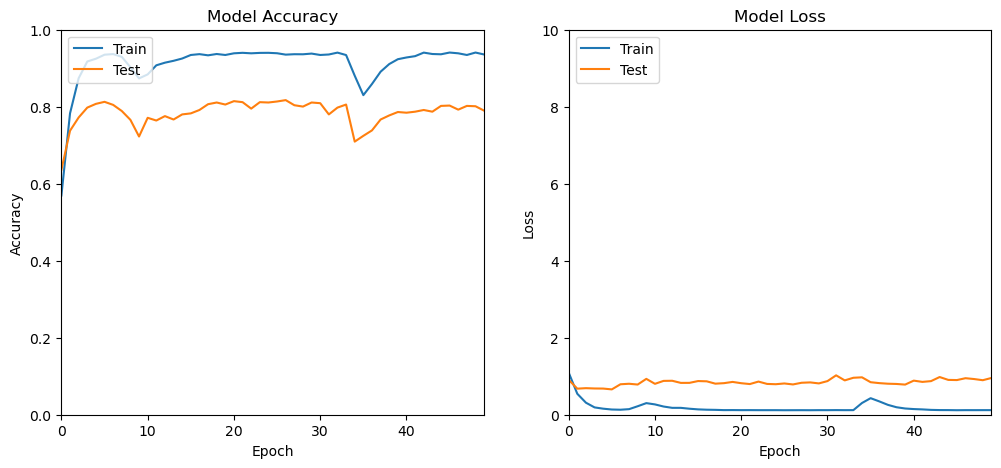

In [6]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0, 49)
plt.ylim(0, 1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_accuracy.png', dpi=300)

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 49)
plt.ylim(0, 10)
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_loss.png', dpi=300)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


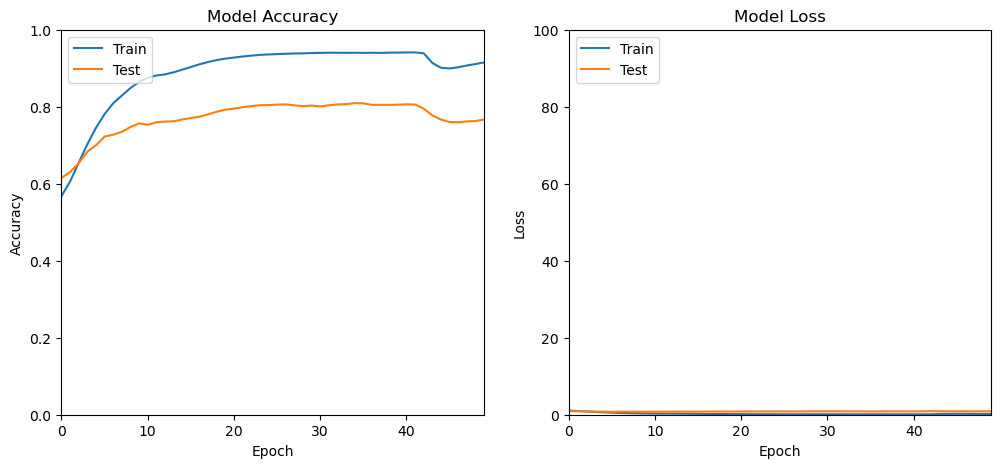

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


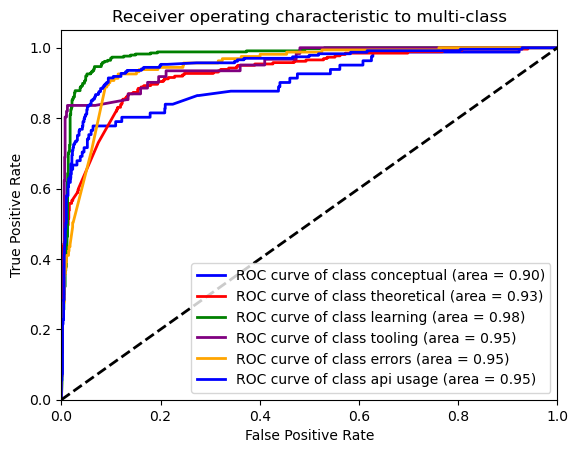

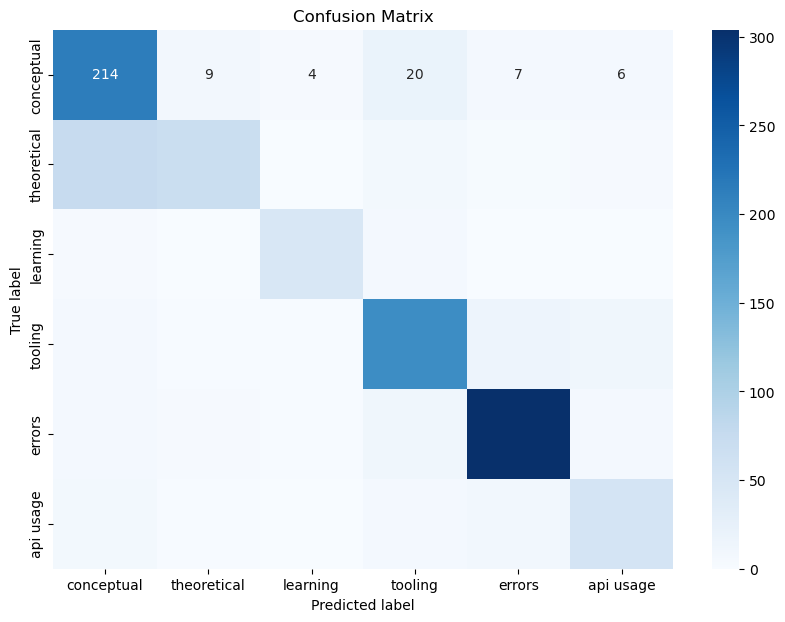

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
import re
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Function to get a synonym
def get_synonym(word):
    synonyms = nltk.corpus.wordnet.synsets(word)
    if synonyms:
        return random.choice(synonyms[0].lemma_names())
    else:
        return word

def augment_text(text, n=1):
    augmented_texts = []
    words = nltk.word_tokenize(text)
    for _ in range(n):
        augmented_text = words.copy()
        augmented_text = [word for word in augmented_text if random.uniform(0, 1) > 0.2]
        for _ in range(2):
            if len(augmented_text) >= 2:
                idx1, idx2 = random.sample(range(len(augmented_text)), 2)
                augmented_text[idx1], augmented_text[idx2] = augmented_text[idx2], augmented_text[idx1]
        for _ in range(2):
            if augmented_text:
                idx = random.randint(0, len(augmented_text) - 1)
                word = get_synonym(augmented_text[idx])
                augmented_text.insert(idx, word)
        augmented_texts.append(' '.join(augmented_text))
    return augmented_texts

# Load and preprocess the dataset
dataset_path = r'All questions answers of Stack Exchange.csv'
df = pd.read_csv(dataset_path, encoding='latin1')
selected_columns = ['QuestionTitle', 'QuestionBody',  'Negotiation']
df = df[selected_columns]
df['text'] = df['QuestionTitle'] + ' ' + df['QuestionBody']
df['text'] = df['text'].str.lower()
df['text'] = df['text'].astype(str).apply(lambda x: re.sub(r'[^\w\s]', '', x))
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
augmented_texts = []
for text in df['text']:
    augmented_texts.extend(augment_text(text, n=1))
df_augmented = pd.DataFrame({'text': df['text'].tolist() + augmented_texts, 'Negotiation': df['Negotiation'].tolist() + [neg for neg in df['Negotiation'].tolist() for _ in range(1)]})
df_augmented.dropna(inplace=True)
df_augmented['Negotiation'] = df_augmented['Negotiation'].str.strip().str.lower()
unique_negotiations_augmented = df_augmented['Negotiation'].unique()
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(df_augmented['text'], df_augmented['Negotiation'], test_size=0.2, random_state=42)
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_augmented['text'])
X_train_augmented = tokenizer.texts_to_sequences(X_train_augmented)
X_test_augmented = tokenizer.texts_to_sequences(X_test_augmented)
X_train_augmented = pad_sequences(X_train_augmented, maxlen=200)
X_test_augmented = pad_sequences(X_test_augmented, maxlen=200)
encoder_augmented = LabelEncoder()
y_train_encoded_augmented = encoder_augmented.fit_transform(y_train_augmented)
y_test_encoded_augmented = encoder_augmented.transform(y_test_augmented)
y_train_one_hot_augmented = to_categorical(y_train_encoded_augmented)
y_test_one_hot_augmented = to_categorical(y_test_encoded_augmented)
oversample_augmented = RandomOverSampler(sampling_strategy='minority')
X_over_augmented, y_over_augmented = oversample_augmented.fit_resample(X_train_augmented, y_train_encoded_augmented)
y_train_one_hot_augmented = to_categorical(y_over_augmented, num_classes=len(unique_negotiations_augmented))
model_augmented = Sequential()
model_augmented.add(Embedding(input_dim=max_features, output_dim=512))
model_augmented.add(Bidirectional(LSTM(64, return_sequences=True)))
model_augmented.add(GlobalMaxPooling1D())
model_augmented.add(Dense(64, activation='relu'))
model_augmented.add(Dense(len(unique_negotiations_augmented), activation='softmax'))
model_augmented.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
history = model_augmented.fit(X_over_augmented, y_train_one_hot_augmented, validation_data=(X_test_augmented, y_test_one_hot_augmented), epochs=50, batch_size=64, verbose=0)

# Smoothing function
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(smooth_curve(history.history['accuracy']))
plt.plot(smooth_curve(history.history['val_accuracy']))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0, 49)
plt.ylim(0, 1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_accuracy.png', dpi=300)

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(smooth_curve(history.history['loss']))
plt.plot(smooth_curve(history.history['val_loss']))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 49)
plt.ylim(0, 100)
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_loss.png', dpi=300)
plt.show()

# Generate predictions and ROC curve
y_pred_proba = model_augmented.predict(X_test_augmented)
y_test_one_hot = label_binarize(y_test_encoded_augmented, classes=np.arange(len(unique_negotiations_augmented)))
n_classes = y_test_one_hot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(unique_negotiations_augmented[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300)
plt.show()

# Confusion Matrix
predictions_augmented = encoder_augmented.inverse_transform(np.argmax(y_pred_proba, axis=1))
cm = confusion_matrix(y_test_augmented, predictions_augmented, labels=unique_negotiations_augmented)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_negotiations_augmented, yticklabels=unique_negotiations_augmented)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nekdilkhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


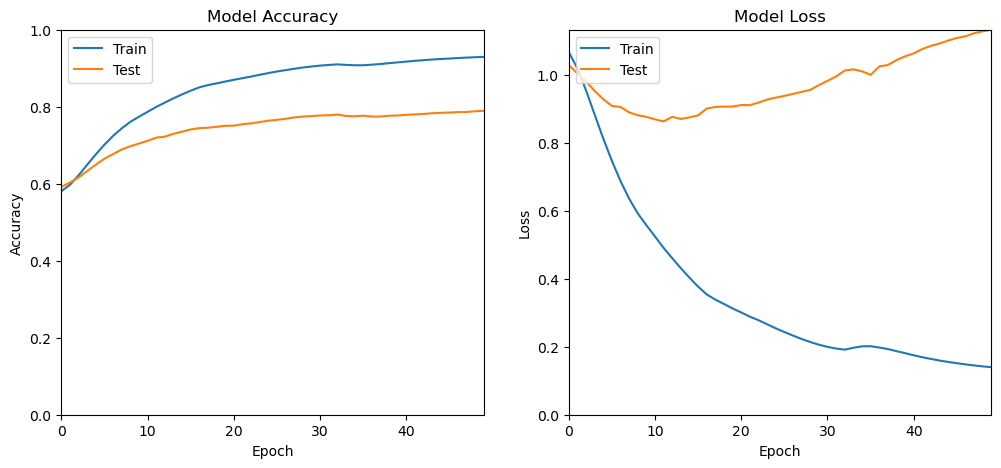

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step


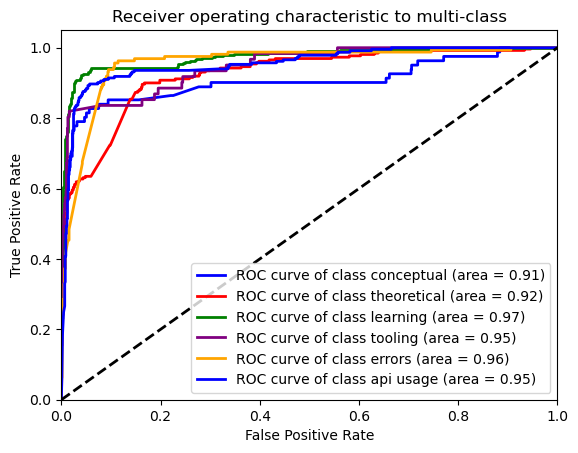

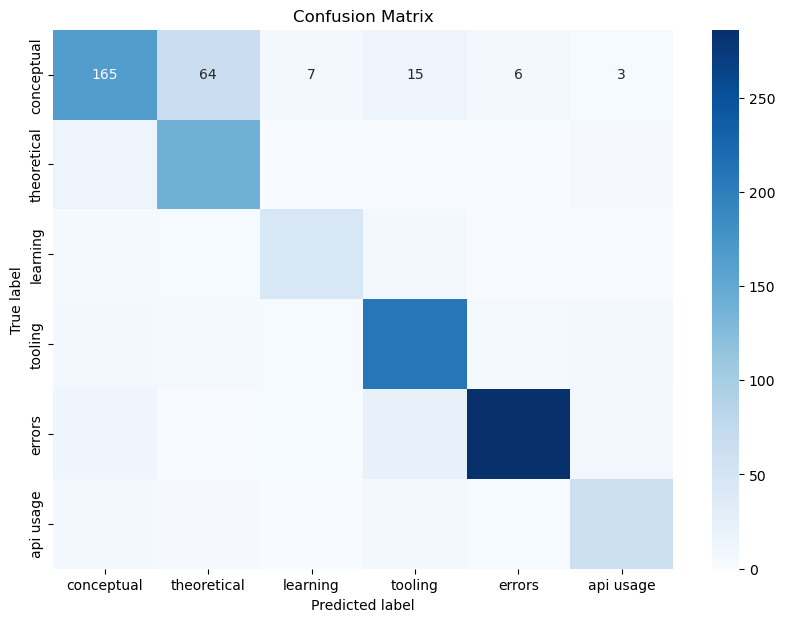

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from itertools import cycle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Bidirectional, LSTM, GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
import re
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Function to get a synonym
def get_synonym(word):
    synonyms = nltk.corpus.wordnet.synsets(word)
    if synonyms:
        return random.choice(synonyms[0].lemma_names())
    else:
        return word

def augment_text(text, n=1):
    augmented_texts = []
    words = nltk.word_tokenize(text)
    for _ in range(n):
        augmented_text = words.copy()
        augmented_text = [word for word in augmented_text if random.uniform(0, 1) > 0.2]
        for _ in range(2):
            if len(augmented_text) >= 2:
                idx1, idx2 = random.sample(range(len(augmented_text)), 2)
                augmented_text[idx1], augmented_text[idx2] = augmented_text[idx2], augmented_text[idx1]
        for _ in range(2):
            if augmented_text:
                idx = random.randint(0, len(augmented_text) - 1)
                word = get_synonym(augmented_text[idx])
                augmented_text.insert(idx, word)
        augmented_texts.append(' '.join(augmented_text))
    return augmented_texts

# Load and preprocess the dataset
dataset_path = r'All questions answers of Stack Exchange.csv'
df = pd.read_csv(dataset_path, encoding='latin1')
selected_columns = ['QuestionTitle', 'QuestionBody',  'Negotiation']
df = df[selected_columns]
df['text'] = df['QuestionTitle'] + ' ' + df['QuestionBody']
df['text'] = df['text'].str.lower()
df['text'] = df['text'].astype(str).apply(lambda x: re.sub(r'[^\w\s]', '', x))
stop = stopwords.words('english')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
augmented_texts = []
for text in df['text']:
    augmented_texts.extend(augment_text(text, n=1))
df_augmented = pd.DataFrame({'text': df['text'].tolist() + augmented_texts, 'Negotiation': df['Negotiation'].tolist() + [neg for neg in df['Negotiation'].tolist() for _ in range(1)]})
df_augmented.dropna(inplace=True)
df_augmented['Negotiation'] = df_augmented['Negotiation'].str.strip().str.lower()
unique_negotiations_augmented = df_augmented['Negotiation'].unique()
X_train_augmented, X_test_augmented, y_train_augmented, y_test_augmented = train_test_split(df_augmented['text'], df_augmented['Negotiation'], test_size=0.2, random_state=42)
max_features = 5000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df_augmented['text'])
X_train_augmented = tokenizer.texts_to_sequences(X_train_augmented)
X_test_augmented = tokenizer.texts_to_sequences(X_test_augmented)
X_train_augmented = pad_sequences(X_train_augmented, maxlen=200)
X_test_augmented = pad_sequences(X_test_augmented, maxlen=200)
encoder_augmented = LabelEncoder()
y_train_encoded_augmented = encoder_augmented.fit_transform(y_train_augmented)
y_test_encoded_augmented = encoder_augmented.transform(y_test_augmented)
y_train_one_hot_augmented = to_categorical(y_train_encoded_augmented)
y_test_one_hot_augmented = to_categorical(y_test_encoded_augmented)
oversample_augmented = RandomOverSampler(sampling_strategy='minority')
X_over_augmented, y_over_augmented = oversample_augmented.fit_resample(X_train_augmented, y_train_encoded_augmented)
y_train_one_hot_augmented = to_categorical(y_over_augmented, num_classes=len(unique_negotiations_augmented))
model_augmented = Sequential()
model_augmented.add(Embedding(input_dim=max_features, output_dim=512))
model_augmented.add(Bidirectional(LSTM(64, return_sequences=True)))
model_augmented.add(GlobalMaxPooling1D())
model_augmented.add(Dense(64, activation='relu'))
model_augmented.add(Dense(len(unique_negotiations_augmented), activation='softmax'))
model_augmented.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])
history = model_augmented.fit(X_over_augmented, y_train_one_hot_augmented, validation_data=(X_test_augmented, y_test_one_hot_augmented), epochs=50, batch_size=64, verbose=0)

# Smoothing function
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(smooth_curve(history.history['accuracy'], factor=0.9))
plt.plot(smooth_curve(history.history['val_accuracy'], factor=0.9))
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xlim(0, 49)
plt.ylim(0, 1)
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_accuracy.png', dpi=300)

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(smooth_curve(history.history['loss'], factor=0.9))
plt.plot(smooth_curve(history.history['val_loss'], factor=0.9))
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 49)
plt.ylim(0, max(max(smooth_curve(history.history['loss'], factor=0.9)), max(smooth_curve(history.history['val_loss'], factor=0.9))))
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('model_loss.png', dpi=300)
plt.show()

# Generate predictions and ROC curve
y_pred_proba = model_augmented.predict(X_test_augmented)
y_test_one_hot = label_binarize(y_test_encoded_augmented, classes=np.arange(len(unique_negotiations_augmented)))
n_classes = y_test_one_hot.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green', 'purple', 'orange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(unique_negotiations_augmented[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png', dpi=300)
plt.show()

# Confusion Matrix
predictions_augmented = encoder_augmented.inverse_transform(np.argmax(y_pred_proba, axis=1))
cm = confusion_matrix(y_test_augmented, predictions_augmented, labels=unique_negotiations_augmented)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_negotiations_augmented, yticklabels=unique_negotiations_augmented)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()
